## Import the necessary software libraries:

In [4]:
import random
import gym
import numpy as np
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

### Create the environment

In [5]:
env = gym.make('MountainCar-v0')
seed_everything(env)

/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/home/ajit.kumar@SNU.IN/Desktop/udemy-rl/utils.py:247: DeprecationWarning: invalid escape sequence '\p'
  plt.title("$\pi(s)$", size=16)


AttributeError: module 'torch' has no attribute 'set_deterministic'

### Create the state aggregation wrapper

In [ ]:
class StateAggregationEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high):
        super().__init__(env)
        self.buckets = [np.linspace(j,k, l-1) for j,k,l in zip(low, high, bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())
        
    def observation(self, obs):
        indices = tuple(np.digitize(i, b) for i,b in zip(obs, self.buckets))
        return indices

In [ ]:
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)

In [ ]:
saenv.buckets

### Compare the original environment to the one with aggregated states

In [ ]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

In [ ]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

### Create the $Q(s,a)$ value table

In [ ]:
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [ ]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [ ]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

In [ ]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

In [ ]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(saenv, policy, 10)

<br><br><br><br>

## Implement Tile Coding

<br><br>

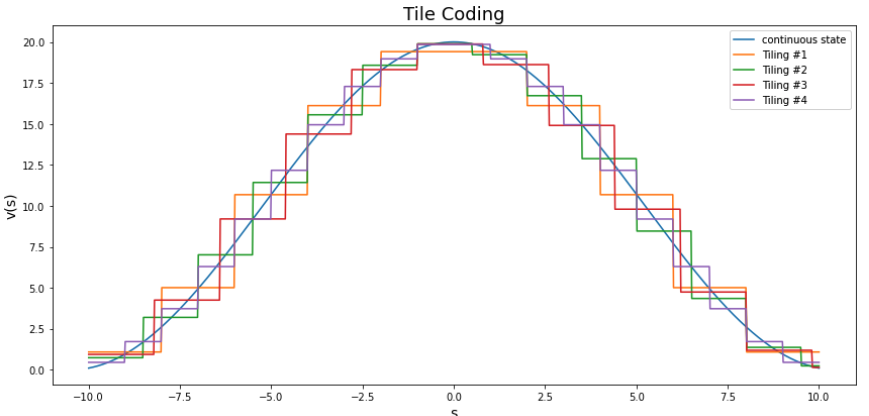

### Create the environment

In [ ]:
env = gym.make('MountainCar-v0')
seed_everything(env)

### Create the Tile Coding wrapper

In [ ]:
class TileCodingEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high, n=4):
        super().__init__(env)
        self.tilings = self._create_tilings(bins, high, low, n)
#         self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())
        
    def observation(self, obs):
        indices = []
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i, b) for i,b in zip(obs, t))
            indices.append(tiling_indices)
        return indices
    
    def _create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1,2*len(bins),2)
        tilings = []
        for i in range(1, n + 1):
            low_i = low - random.random() * .2 * low
            high_i = high + random.random() * .2 * high
            segment_sizes = (high_i - low_i) / bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_sizes / n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(j,k, l-1) for j,k,l in zip(low_i, high_i, bins)]
            tilings.append(buckets_i)
        return tilings


In [ ]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

### Compare the original environment to the one with aggregated states

In [ ]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

In [ ]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

### Create the $Q(s,a)$ value table

In [ ]:
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
        
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [ ]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [ ]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

In [ ]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

In [ ]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(tcenv, policy, 2)

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)